<div class="alert alert-success">
<h1>Advanced Statistical Inference</h1>
<h2>Assessed Exercise</h2>
</div>

<div class="alert alert-warning">
<h3>Introduction and Instruction</h3>
<br>
In this work you will analyze the MNIST and CIFAR10 datasets available to download from:
<br>
<ul>
<li>http://yann.lecun.com/exdb/mnist/
<li>https://www.cs.toronto.edu/~kriz/cifar.html
</ul>
<br>
Listed below are various exercises to undertake.
</div>

<div class="alert alert-info">
Download the MNIST and CIFAR10 datasets and import them.
</div>

In [1]:
from keras.datasets import mnist, cifar10

(mnist_train_data, mnist_train_label), (mnist_test_data, mnist_test_label) = mnist.load_data()
(cifar10_train_data, cifar10_train_label), (cifar10_test_data, cifar10_test_label) = cifar10.load_data()

Using TensorFlow backend.


<div class="alert alert-info">
Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.
</div>

In [2]:
import os
import sys
import re
import random
import functools

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from time import time

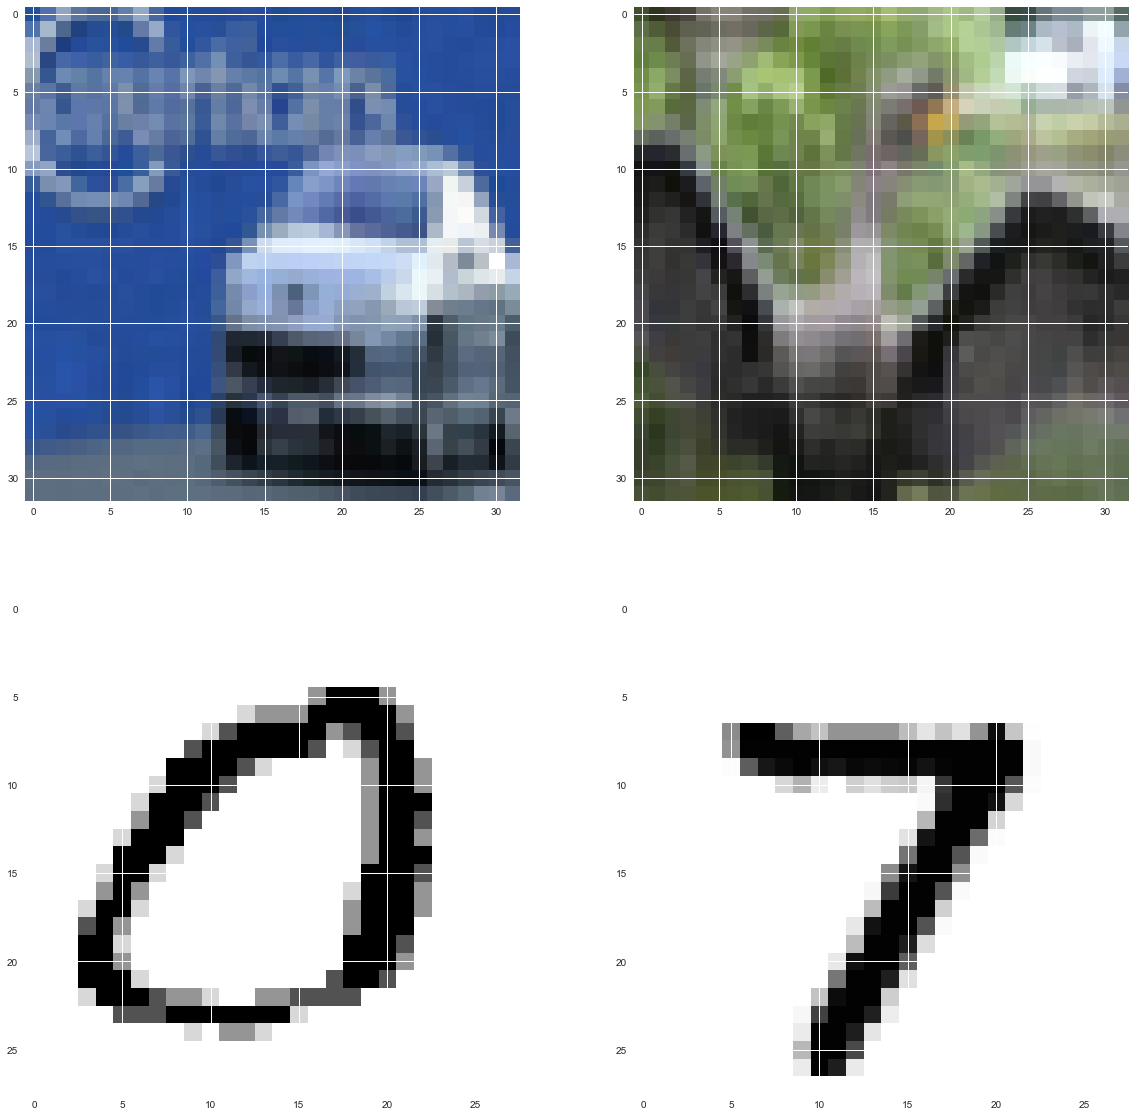

In [3]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(cifar10_test_data[np.random.randint(0, len(cifar10_test_data))])
plt.subplot(222)
plt.imshow(cifar10_test_data[np.random.randint(0, len(cifar10_test_data))])
plt.subplot(223)
plt.imshow(mnist_test_data[np.random.randint(0, len(mnist_test_data))])
plt.subplot(224)
plt.imshow(mnist_test_data[np.random.randint(0, len(mnist_test_data))])
plt.show()

<div class="alert alert-danger">
TODO comment figures, plot distribution of labels
</div>

<div class="alert alert-warning">
<h3>Classification</h3>
</div>

<div class="alert alert-info">
Implement the Naïve Bayes classifier.
</div>

<div class="alert alert-success">
The naïve Bayes classifier is a very simple probabilistic classifier based on Bayes rule:
<br><br>
\begin{equation}
P(\ t_{new}=k \ \vert \ \mathbf{X},\mathbf{t},\mathbf{x}_{new}\ )
= \frac {P(\ \mathbf{x}_{new} \ \vert \ t_{new}=k, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )}
        {\sum_jP(\ \mathbf{x}_{new} \ \vert \ t_{new} = j, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )}
\end{equation}
<br><br>
given that:
<ul>
<li>$\mathbf{X}$ is the data of our training set
<li>$\mathbf{t}$ are the labels of our training set
<li>$\mathbf{x}_{new}$ is the sample we want to classify
<li>$t_{new}$ is the class of our sample we want to evaluate
</ul>
<br><br>
We define the elements of the Bayes rule as:
<ul>
<li><b>Posterior</b>: $P(\ t_{new}=k \ \vert \ \mathbf{X},\mathbf{t},\mathbf{x}_{new}\ )$
<ul><li>It's the probability of $\mathbf{x}_{new}$ belonging to class $k$ given the training set $\mathbf{X}$ and its labels $\mathbf{t}$</ul>
<li><b>Likelihood</b>: $P(\ \mathbf{x}_{new} \ \vert \ t_{new}=k, \mathbf{X},\mathbf{t} \ )$
<ul><li>It is a density (<b>not</b> a probability) telling how likely it is that, given that the label of the element is $k$, we are able to see an element like $\mathbf{x}_{new}$</ul>
<li><b>Prior</b>: $P( \ t_{new}=k \ )$
<ul><li>It is the probability of finding the label $k$ without any observations on the data.</ul>
<li><b>Marginal likelihood</b>: $\sum_jP(\ \mathbf{x}_{new} \ \vert \ t_{new} = j, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )$
<ul><li>Normalisation constant.</ul>
</ul>
<br><br>
The <i>likelihood</i> for a label $k$ is defined as:
\begin{equation}
\prod\limits_{d=1}^{K}\mathcal{N}(\mu_{kd}, \ \sigma^2_{kd})
\end{equation}
where $\mu_{kd}$ and $\sigma^2_{kd}$ are:
\begin{align*}
\mu_{kd} =& \ \frac{1}{N_k} \ \sum\limits_{n:t_n=k} x_{nd} \\
\sigma^2_{kd} =& \ \frac{1}{N_k} \ \sum\limits_{n:t_n=k} (x_{nd} - \mu_{kd})^2
\end{align*}
</div>

In [66]:
def get_prior(data, size):
    return len(data)/size
    
def get_means_and_variances(data):
    return (np.array(data).mean(axis=0), np.array(data).var(axis=0)+1e-3)

def get_likelihood(means, variances, sample):
    def gauss(mean, var, sample_d):
        return np.exp(-(sample_d-mean)/(2*var)) / np.sqrt(2*np.pi*var)
    return functools.reduce(lambda x,y: np.float128(x)*np.float128(y), \
                            [gauss(a, b, c) for a,b,c in zip(means, variances, sample)])


def get_marginal_likelihood(likelihoods, priors):
    return np.sum([x*y for x,y in zip(likelihoods, priors)])

def get_posterior(likelihood, prior, marginal_likelihood):
    print(likelihood, prior, marginal_likelihood)
    return likelihood*prior/marginal_likelihood

def predict(data, labels, samples, norm=None, mnist=True):
    train_size = len(data)
    test_size = len(samples)
        
    data = data.reshape(train_size, -1)
    samples = samples.reshape(test_size, -1)

    if norm:
        data = data/norm
        samples = samples/norm
        
    dict_per_label = {k:[] for k in np.unique(labels)}
    for _ in np.arange(train_size):
        if mnist is True:
            dict_per_label[labels[_]].append(data[_])
        else:
            dict_per_label[labels[_][0]].append(data[_])
                
    priors = [get_prior(dict_per_label[k], train_size) for k in np.unique(labels)]
    #print priors
    
    means_and_variances = [get_means_and_variances(dict_per_label[k]) for k in np.unique(labels)]
    predictions = []
    
    for sample in samples:
        likelihoods = [get_likelihood(_[0], _[1], sample) for _ in means_and_variances]
        marginal_likelihood = get_marginal_likelihood(likelihoods, priors)
        probabilities_k = [get_posterior(likelihoods[k], priors[k], marginal_likelihood) for k in np.unique(labels)]
        #print(probabilities_k)
        predictions.append(np.argmax(probabilities_k))
        
    return predictions

In [ ]:
import time
t1 = time.time()
predictions = predict(mnist_train_data, mnist_train_label, mnist_test_data, norm=255)
print(time.time()-t1)

In [172]:
correct = 0
for k in np.arange(len(mnist_test_data)):
    if predictions[k] == mnist_test_label[k]:
        correct += 1
        
print(correct)

7150


In [49]:
predict(mnist_train_data, mnist_train_label, mnist_test_data[3:4], norm=255)

shape before (1, 28, 28) 1
shape after (1, 784) 1


[0]

In [67]:
predict(cifar10_train_data, cifar10_train_label, cifar10_test_data[2000:2001], mnist=False)

0.0 0.1 0.0
0.0 0.1 0.0
0.0 0.1 0.0
0.0 0.1 0.0
0.0 0.1 0.0
0.0 0.1 0.0
0.0 0.1 0.0
0.0 0.1 0.0
0.0 0.1 0.0
0.0 0.1 0.0


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in longdouble_scalars


[0]

<div class="alert alert-danger">
TODO explain zero frequency problem (why we summed one everywhere)
</div>